In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import gc
import joblib
import re
from collections import Counter
from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, roc_auc_score,
                           roc_curve, classification_report,
                           precision_recall_curve, average_precision_score)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Dense, Dropout,
                                   LayerNormalization, MultiHeadAttention,
                                   GlobalAveragePooling1D, Add, Concatenate,
                                   Reshape, BatchNormalization)
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                      ModelCheckpoint, TensorBoard)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

In [328]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)
tf.random.set_seed(42)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [329]:
train_df = pd.read_csv('../dataset/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('../dataset/UNSW_NB15_testing-set.csv')

print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)
print(f"\nTotal Samples: {train_df.shape[0] + test_df.shape[0]:,}")

Training Data Shape: (175341, 45)
Testing Data Shape: (82332, 45)

Total Samples: 257,673


In [330]:
train_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.1215,tcp,-,FIN,6,4,258,172,74.0875,252,254,14158.9424,8495.3652,0,0,24.2956,8.3750,30.1775,11.8306,255,621772692,2202533631,255,0.0000,0.0000,0.0000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.6499,tcp,-,FIN,14,38,734,42014,78.4734,62,252,8395.1123,503571.3125,2,17,49.9150,15.4329,61.4269,1387.7783,255,1417884146,3077387971,255,0.0000,0.0000,0.0000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.6231,tcp,-,FIN,8,16,364,13186,14.1702,62,252,1572.2719,60929.2305,1,6,231.8756,102.7372,17179.5869,11420.9262,255,2116150707,2963114973,255,0.1119,0.0615,0.0504,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.6816,tcp,ftp,FIN,12,12,628,770,13.6771,62,252,2740.1790,3358.6221,1,3,152.8765,90.2357,259.0802,4991.7847,255,1107119177,1047442890,255,0.0000,0.0000,0.0000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.4495,tcp,-,FIN,10,6,534,268,33.3738,254,252,8561.4990,3987.0598,2,1,47.7503,75.6596,2415.8376,115.8070,255,2436137549,1977154190,255,0.1284,0.0711,0.0572,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0


In [331]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000,175341.0000
mean,87671.0000,1.3594,20.2987,18.9696,8844.8438,14928.9186,95406.1871,179.5470,79.6096,73454033.1941,671205.5742,4.9530,6.9480,985.9769,88.2163,4976.2542,604.3538,116.2573,969250421.9105,968877027.0712,115.0136,0.0414,0.0210,0.0204,136.7518,124.1734,0.1060,2144.2917,9.3064,1.3042,6.1939,5.3835,4.2063,8.7299,0.0149,0.0149,0.1331,6.9558,9.1008,0.0158,0.6806
std,50616.7311,6.4802,136.8876,110.2583,174765.6443,143654.2177,165400.9785,102.9400,110.5069,188357447.0002,2421312.3888,66.0051,52.7330,7242.2458,987.0932,44965.8465,4061.0433,127.0010,1355264249.2630,1353999546.2257,126.8865,0.0794,0.0434,0.0405,204.6774,258.3171,0.7769,54207.9673,10.7043,0.9544,8.0525,8.0471,5.7836,10.9562,0.1260,0.1260,0.7012,8.3215,10.7570,0.1245,0.4662
min,1.0000,0.0000,1.0000,0.0000,28.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,28.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000
25%,43836.0000,0.0000,2.0000,0.0000,114.0000,0.0000,32.7861,62.0000,0.0000,13053.3389,0.0000,0.0000,0.0000,0.0080,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,57.0000,0.0000,0.0000,0.0000,2.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,2.0000,2.0000,0.0000,0.0000
50%,87671.0000,0.0016,2.0000,2.0000,430.0000,164.0000,3225.8065,254.0000,29.0000,879674.7500,1447.0227,0.0000,0.0000,0.2797,0.0060,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,73.0000,44.0000,0.0000,0.0000,5.0000,1.0000,2.0000,1.0000,1.0000,3.0000,0.0000,0.0000,0.0000,3.0000,4.0000,0.0000,1.0000
75%,131506.0000,0.6681,12.0000,10.0000,1418.0000,1102.0000,125000.0003,254.0000,252.0000,88888888.0000,27844.8711,3.0000,2.0000,55.1569,51.0530,2513.2950,114.9906,255.0000,1916651334.0000,1913674673.0000,255.0000,0.0655,0.0233,0.0389,100.0000,89.0000,0.0000,0.0000,12.0000,2.0000,7.0000,5.0000,3.0000,12.0000,0.0000,0.0000,0.0000,9.0000,12.0000,0.0000,1.0000
max,175341.0000,60.0000,9616.0000,10974.0000,12965233.0000,14655550.0000,1000000.0030,255.0000,254.0000,5988000256.0000,22422730.0000,4803.0000,5484.0000,84371.4960,56716.8240,1460480.0160,289388.2697,255.0000,4294958913.0000,4294881924.0000,255.0000,2.5189,2.1004,1.5209,1504.0000,1458.0000,172.0000,6558056.0000,63.0000,6.0000,51.0000,51.0000,46.0000,65.0000,4.0000,4.0000,30.0000,60.0000,62.0000,1.0000,1.0000


In [332]:
train_df.isnull().sum()


id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [333]:
print("\nLabel Distribution:")
print(train_df['label'].value_counts())
print("\nLabel Distribution (%):")
print(train_df['label'].value_counts(normalize=True) * 100)


Label Distribution:
label
1    119341
0     56000
Name: count, dtype: int64

Label Distribution (%):
label
1   68.0622
0   31.9378
Name: proportion, dtype: float64


In [334]:
test_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.0000,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0000,0.0000,0,0,0.0110,0.0000,0.0000,0.0000,0,0,0,0,0.0000,0.0000,0.0000,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.0000,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0000,0.0000,0,0,0.0080,0.0000,0.0000,0.0000,0,0,0,0,0.0000,0.0000,0.0000,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.0000,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0000,0.0000,0,0,0.0050,0.0000,0.0000,0.0000,0,0,0,0,0.0000,0.0000,0.0000,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.0000,udp,-,INT,2,0,900,0,166666.6608,254,0,600000000.0000,0.0000,0,0,0.0060,0.0000,0.0000,0.0000,0,0,0,0,0.0000,0.0000,0.0000,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.0000,udp,-,INT,2,0,2126,0,100000.0025,254,0,850400000.0000,0.0000,0,0,0.0100,0.0000,0.0000,0.0000,0,0,0,0,0.0000,0.0000,0.0000,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0


In [335]:
test_df.info()
test_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000,82332.0000
mean,41166.5000,1.0068,18.6665,17.5459,7993.9082,13233.7856,82410.8867,180.9677,95.7130,64549016.9141,630546.9590,4.7537,6.3086,755.3943,121.7013,6363.0751,535.1804,133.4591,1084641551.1153,1073464670.8804,128.2866,0.0559,0.0293,0.0267,139.5286,116.2751,0.0943,1595.3719,9.5466,1.3693,5.7449,4.9289,3.6630,7.4564,0.0083,0.0084,0.1297,6.4684,9.1643,0.0111,0.5506
std,23767.3455,4.7104,133.9164,115.5741,171642.2619,151471.4561,148620.3670,101.5134,116.6677,179861832.6300,2393000.5556,64.6496,55.7080,6182.6157,1292.3785,56724.0167,3635.3054,127.3570,1390859761.6104,1381996192.0328,127.4914,0.1160,0.0709,0.0551,208.4721,244.6003,0.5429,38066.9723,11.0903,1.0672,8.4181,8.3895,5.9154,11.4152,0.0912,0.0925,0.6387,8.5439,11.1214,0.1049,0.4974
min,1.0000,0.0000,1.0000,0.0000,24.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,24.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000
25%,20583.7500,0.0000,2.0000,0.0000,114.0000,0.0000,28.6061,62.0000,0.0000,11202.4668,0.0000,0.0000,0.0000,0.0080,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,57.0000,0.0000,0.0000,0.0000,2.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,1.0000,2.0000,0.0000,0.0000
50%,41166.5000,0.0141,6.0000,2.0000,534.0000,178.0000,2650.1767,254.0000,29.0000,577003.2188,2112.9514,1.0000,0.0000,0.5579,0.0100,17.6239,0.0000,255.0000,27888855.0000,28569748.5000,255.0000,0.0006,0.0004,0.0001,65.0000,44.0000,0.0000,0.0000,5.0000,1.0000,2.0000,1.0000,1.0000,3.0000,0.0000,0.0000,0.0000,3.0000,5.0000,0.0000,1.0000
75%,61749.2500,0.7194,12.0000,10.0000,1280.0000,956.0000,111111.1072,254.0000,252.0000,65142856.0000,15858.0823,3.0000,2.0000,63.4094,63.1364,3219.3324,128.4599,255.0000,2171309606.5000,2144205173.0000,255.0000,0.1055,0.0526,0.0488,100.0000,87.0000,0.0000,0.0000,11.0000,2.0000,6.0000,4.0000,3.0000,6.0000,0.0000,0.0000,0.0000,7.0000,11.0000,0.0000,1.0000
max,82332.0000,60.0000,10646.0000,11018.0000,14355774.0000,14657531.0000,1000000.0030,255.0000,253.0000,5268000256.0000,20821108.0000,5319.0000,5507.0000,60009.9920,57739.2400,1483830.9170,463199.2401,255.0000,4294949667.0000,4294880717.0000,255.0000,3.8215,3.2268,2.9288,1504.0000,1500.0000,131.0000,5242880.0000,63.0000,6.0000,59.0000,59.0000,38.0000,63.0000,2.0000,2.0000,16.0000,60.0000,62.0000,1.0000,1.0000


In [336]:
test_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [337]:
print("\nLabel Distribution:")
print(test_df['label'].value_counts())
print("\nLabel Distribution (%):")
print(test_df['label'].value_counts(normalize=True) * 100)


Label Distribution:
label
1    45332
0    37000
Name: count, dtype: int64

Label Distribution (%):
label
1   55.0600
0   44.9400
Name: proportion, dtype: float64


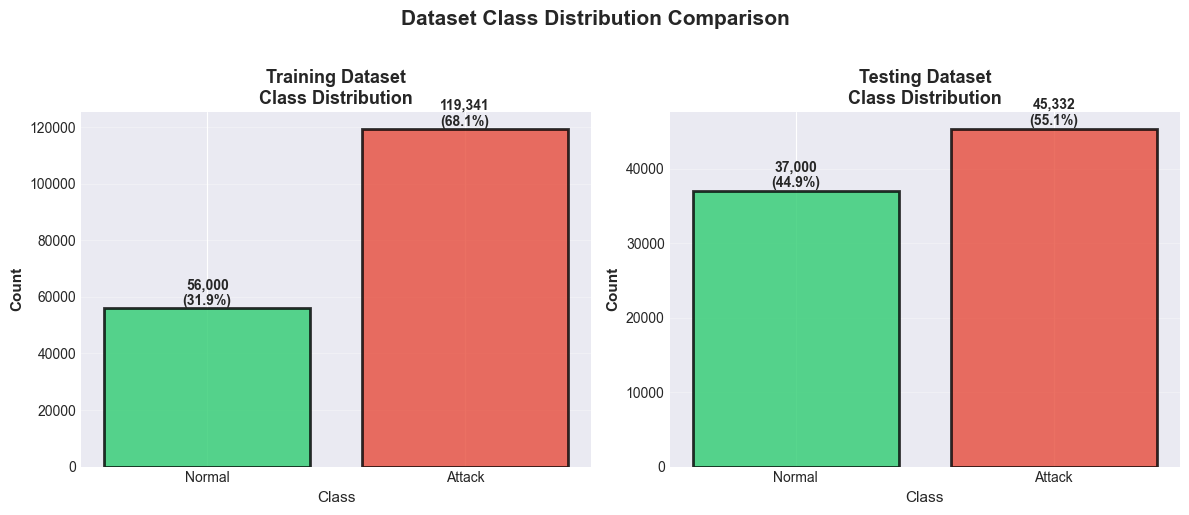

In [338]:
import matplotlib.pyplot as plt

train_counts = train_df['label'].value_counts()
test_counts = test_df['label'].value_counts()
colors = ['#2ecc71', '#e74c3c']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(['Normal', 'Attack'], 
        [train_counts[0], train_counts[1]], 
        color=colors, alpha=0.8, edgecolor='black', linewidth=2)

plt.title('Training Dataset\nClass Distribution', fontsize=13, fontweight='bold')
plt.ylabel('Count', fontsize=11, fontweight='bold')
plt.xlabel('Class', fontsize=11)
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate([train_counts[0], train_counts[1]]):
    plt.text(i, v + 1000, f'{v:,}\n({v/len(train_df)*100:.1f}%)',
             ha='center', fontweight='bold', fontsize=10)

plt.subplot(1, 2, 2)
plt.bar(['Normal', 'Attack'], 
        [test_counts[0], test_counts[1]], 
        color=colors, alpha=0.8, edgecolor='black', linewidth=2)

plt.title('Testing Dataset\nClass Distribution', fontsize=13, fontweight='bold')
plt.ylabel('Count', fontsize=11, fontweight='bold')
plt.xlabel('Class', fontsize=11)
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate([test_counts[0], test_counts[1]]):
    plt.text(i, v + 500, f'{v:,}\n({v/len(test_df)*100:.1f}%)',
             ha='center', fontweight='bold', fontsize=10)

plt.suptitle('Dataset Class Distribution Comparison', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64

Percentage:
attack_cat
Normal           31.9400
Generic          22.8100
Exploits         19.0400
Fuzzers          10.3700
DoS               6.9900
Reconnaissance    5.9800
Analysis          1.1400
Backdoor          1.0000
Shellcode         0.6500
Worms             0.0700
Name: count, dtype: float64


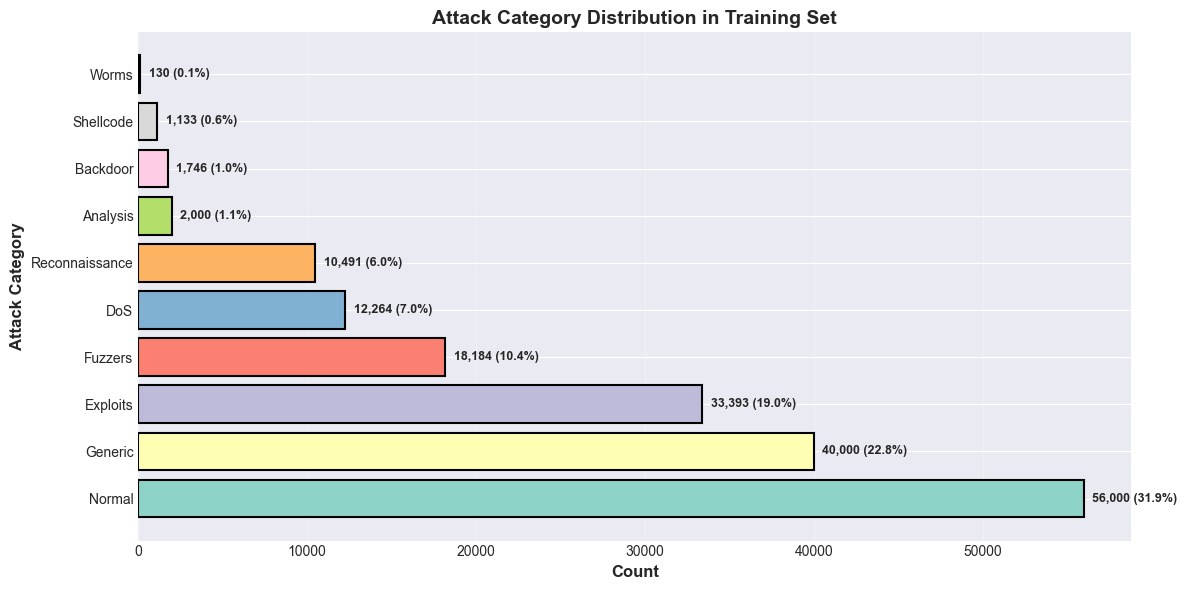

In [339]:
attack_train = train_df['attack_cat'].value_counts()
print(attack_train)
print("\nPercentage:")
print((attack_train / len(train_df) * 100).round(2))

plt.figure(figsize=(12, 6))
colors_attack = plt.cm.Set3(range(len(attack_train)))
bars = plt.barh(range(len(attack_train)), attack_train.values, 
               color=colors_attack, edgecolor='black', linewidth=1.5)
plt.yticks(range(len(attack_train)), attack_train.index, fontsize=10)
plt.xlabel('Count', fontsize=12, fontweight='bold')
plt.ylabel('Attack Category', fontsize=12, fontweight='bold')
plt.title('Attack Category Distribution in Training Set', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, (bar, v) in enumerate(zip(bars, attack_train.values)):
    plt.text(v + 500, i, f'{v:,} ({v/len(train_df)*100:.1f}%)', 
            va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

In [340]:
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'id' in numerical_cols:
    numerical_cols.remove('id')
if 'label' in numerical_cols:
    numerical_cols.remove('label')

categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
if 'attack_cat' in categorical_cols:
    categorical_cols.remove('attack_cat')

print(f"Total Features: {len(numerical_cols) + len(categorical_cols)}")
print(f"\nNumerical Features ({len(numerical_cols)}):")
for i, col in enumerate(numerical_cols, 1):
    print(f"  {i:2d}. {col}")

print(f"\nCategorical Features ({len(categorical_cols)}):")
for i, col in enumerate(categorical_cols, 1):
    print(f"  {i}. {col}")

Total Features: 42

Numerical Features (39):
   1. dur
   2. spkts
   3. dpkts
   4. sbytes
   5. dbytes
   6. rate
   7. sttl
   8. dttl
   9. sload
  10. dload
  11. sloss
  12. dloss
  13. sinpkt
  14. dinpkt
  15. sjit
  16. djit
  17. swin
  18. stcpb
  19. dtcpb
  20. dwin
  21. tcprtt
  22. synack
  23. ackdat
  24. smean
  25. dmean
  26. trans_depth
  27. response_body_len
  28. ct_srv_src
  29. ct_state_ttl
  30. ct_dst_ltm
  31. ct_src_dport_ltm
  32. ct_dst_sport_ltm
  33. ct_dst_src_ltm
  34. is_ftp_login
  35. ct_ftp_cmd
  36. ct_flw_http_mthd
  37. ct_src_ltm
  38. ct_srv_dst
  39. is_sm_ips_ports

Categorical Features (3):
  1. proto
  2. service
  3. state


In [341]:
selected_stats_cols = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate']

print("\nNormal Traffic Statistics:")
print(train_df[train_df['label'] == 0][selected_stats_cols].describe())

print("\nAttack Traffic Statistics:")
print(train_df[train_df['label'] == 1][selected_stats_cols].describe())


Normal Traffic Statistics:
             dur      spkts      dpkts      sbytes       dbytes         rate
count 56000.0000 56000.0000 56000.0000  56000.0000   56000.0000   56000.0000
mean      1.0172    30.7255    38.0577   4105.7029   31049.4631   13799.3121
std       4.8592    57.3441   105.7733  11348.0538  139991.2507   68031.3945
min       0.0000     1.0000     0.0000     28.0000       0.0000       0.0000
25%       0.0017     4.0000     2.0000    424.0000     178.0000      30.7307
50%       0.0386    12.0000    10.0000   1470.0000    1112.0000    1382.2566
75%       0.6398    40.0000    40.0000   3401.5000   10168.0000    3177.6928
max      60.0000   656.0000  1716.0000 338718.0000 2249492.0000 1000000.0030

Attack Traffic Statistics:
              dur       spkts       dpkts        sbytes        dbytes  \
count 119341.0000 119341.0000 119341.0000   119341.0000   119341.0000   
mean       1.5200     15.4059     10.0126    11068.6554     7364.4563   
std        7.1090    160.9755   

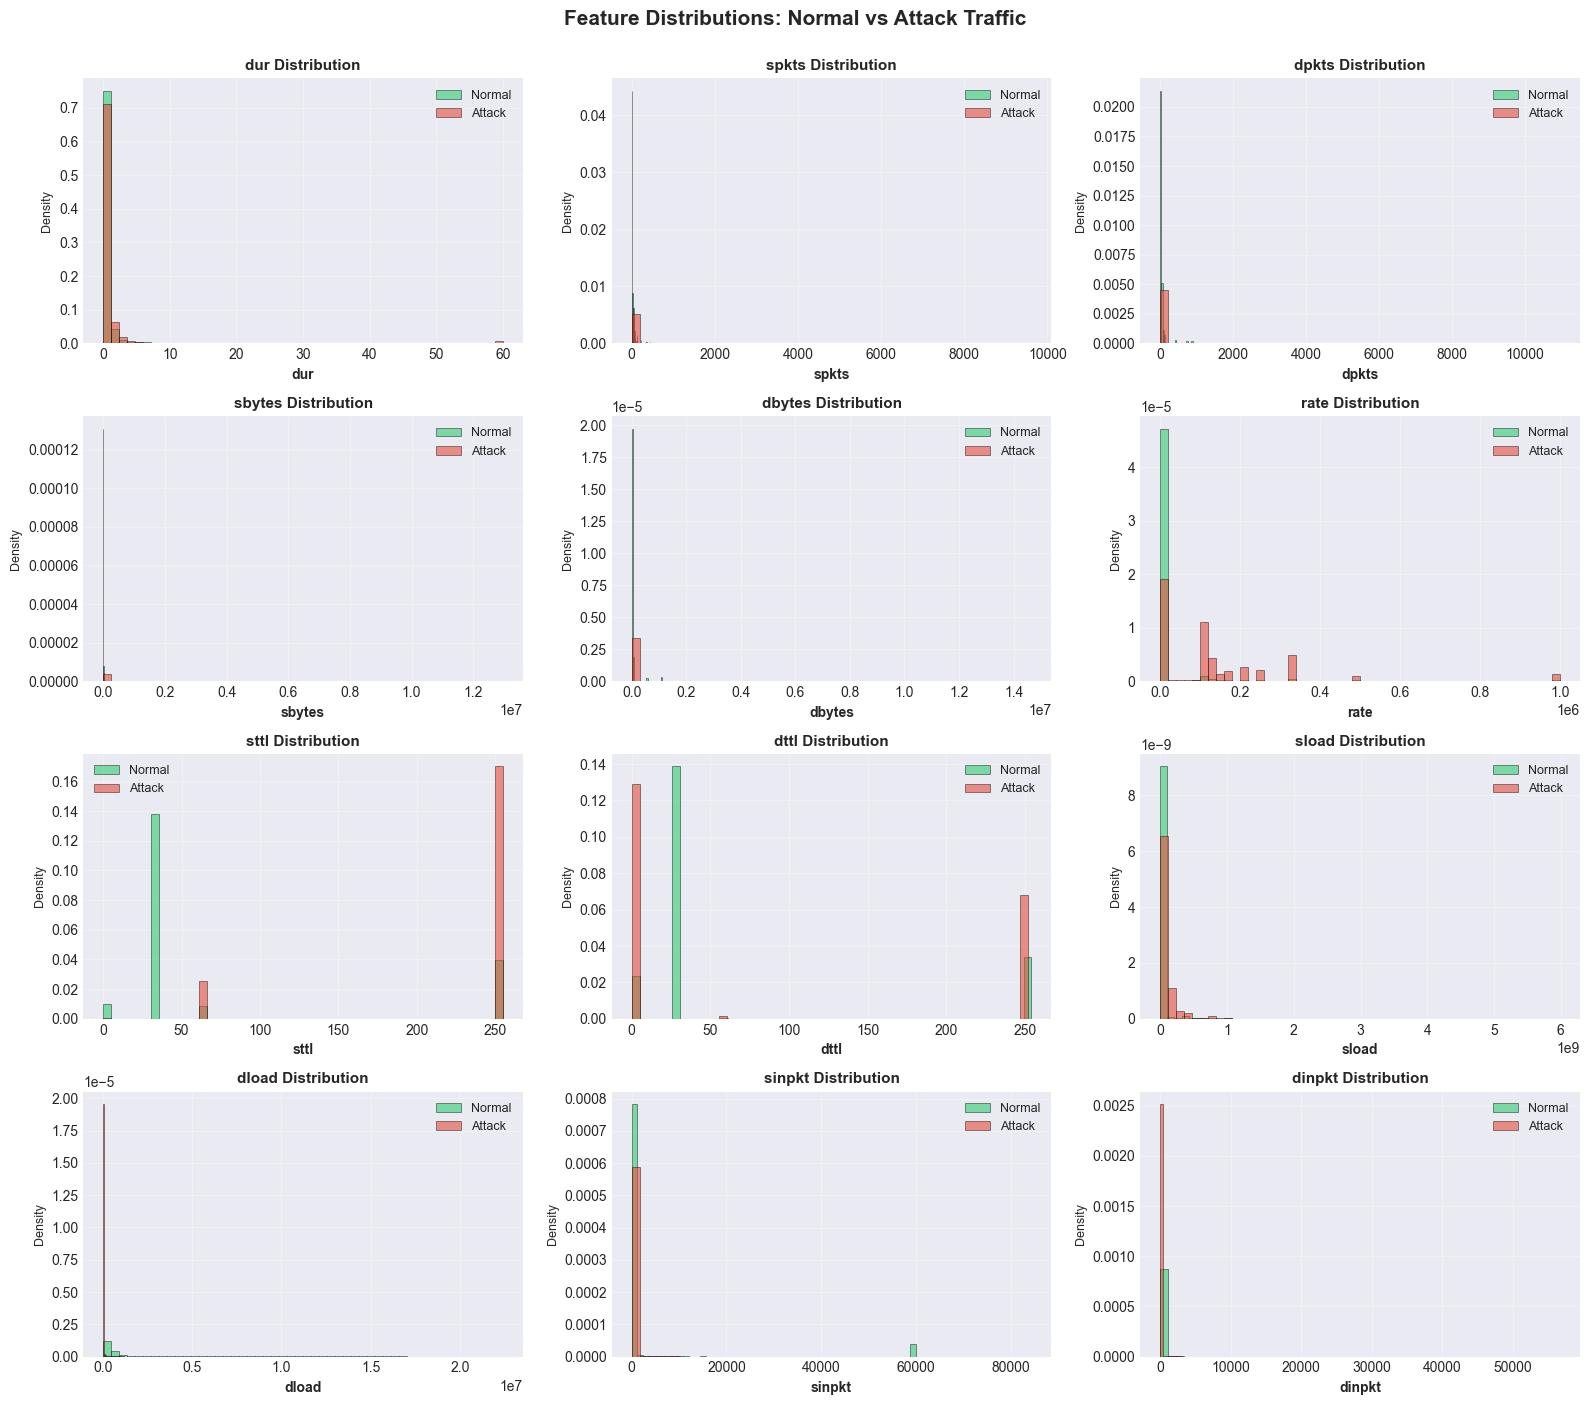

In [342]:
selected_features = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate',
                     'sttl', 'dttl', 'sload', 'dload', 'sinpkt', 'dinpkt']

plt.figure(figsize=(16, 14))

for idx, feature in enumerate(selected_features, start=1):
    plt.subplot(4, 3, idx)
    data_normal = train_df[train_df['label'] == 0][feature].dropna()
    data_attack = train_df[train_df['label'] == 1][feature].dropna()

    plt.hist(data_normal, bins=50, alpha=0.6, label='Normal',
             color='#2ecc71', density=True, edgecolor='black', linewidth=0.5)
    plt.hist(data_attack, bins=50, alpha=0.6, label='Attack',
             color='#e74c3c', density=True, edgecolor='black', linewidth=0.5)

    plt.xlabel(feature, fontsize=10, fontweight='bold')
    plt.ylabel('Density', fontsize=9)
    plt.title(f'{feature} Distribution', fontsize=11, fontweight='bold')
    plt.legend(fontsize=9)
    plt.grid(alpha=0.3)

plt.suptitle('Feature Distributions: Normal vs Attack Traffic', fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


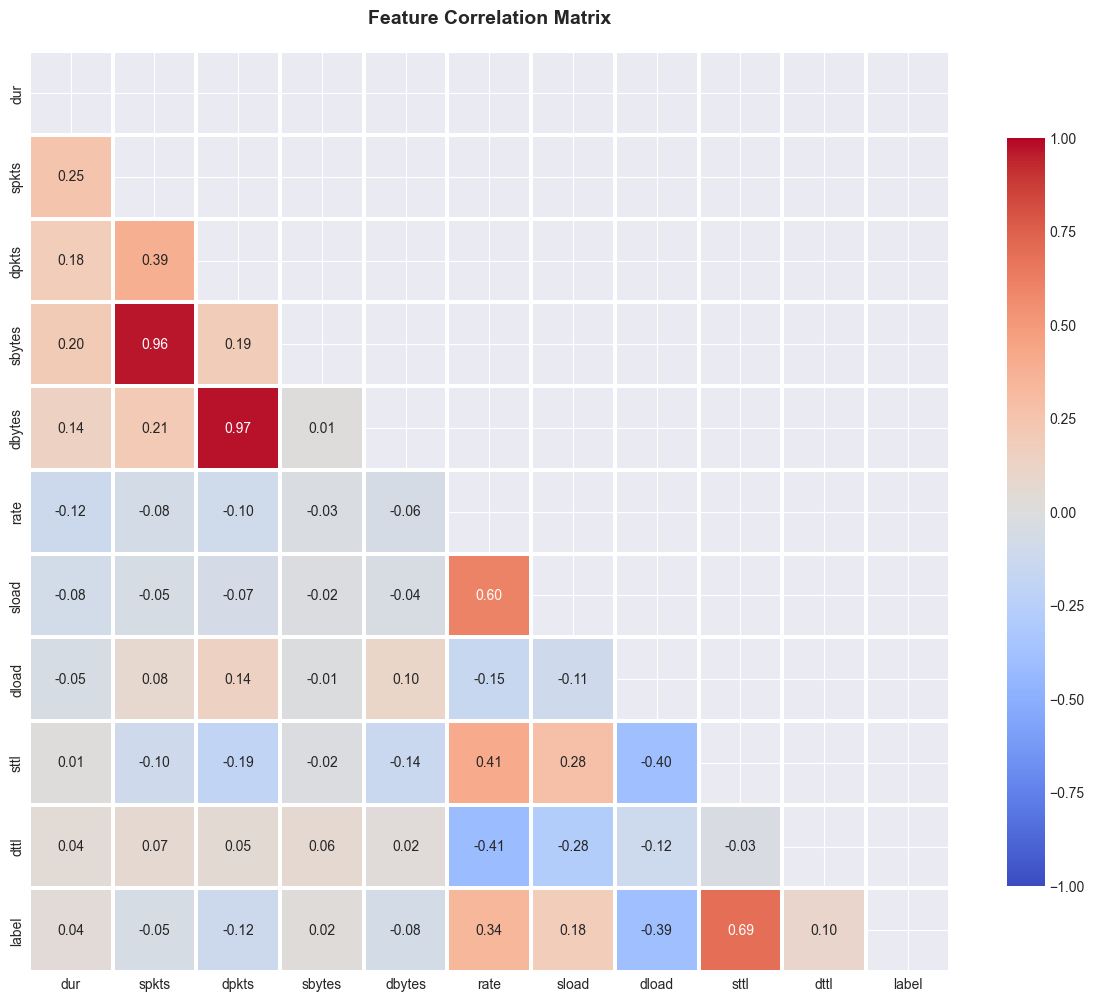

In [343]:
corr_features = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 
                'sload', 'dload', 'sttl', 'dttl', 'label']
corr_matrix = train_df[corr_features].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


In [344]:
train_data = train_df.copy()
test_data = test_df.copy()

for col in numerical_cols:
    train_data[col].fillna(0, inplace=True)
    test_data[col].fillna(0, inplace=True)

for col in categorical_cols:
    train_data[col].fillna('unknown', inplace=True)
    test_data[col].fillna('unknown', inplace=True)

print(f"Training set missing values: {train_data.isnull().sum().sum()}")
print(f"Testing set missing values: {test_data.isnull().sum().sum()}")

Training set missing values: 0
Testing set missing values: 0


In [345]:
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    
    train_data[col] = train_data[col].astype(str)
    test_data[col] = test_data[col].astype(str)
    
    all_categories = list(set(train_data[col].unique()) | set(test_data[col].unique()))
    le.fit(all_categories)
    
    train_data[col] = le.transform(train_data[col])
    test_data[col] = le.transform(test_data[col])
    
    label_encoders[col] = le
    print(f"  {col}: {len(le.classes_)} unique values encoded")


  proto: 133 unique values encoded
  service: 13 unique values encoded
  state: 11 unique values encoded


In [346]:
scaler = StandardScaler()

train_data[numerical_cols] = scaler.fit_transform(train_data[numerical_cols])
test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

print("\nScaled features statistics (Training):")
print(train_data[numerical_cols].describe().loc[['mean', 'std']].round(4))


Scaled features statistics (Training):
         dur   spkts  dpkts  sbytes  dbytes    rate    sttl    dttl  sload  \
mean -0.0000 -0.0000 0.0000 -0.0000  0.0000 -0.0000 -0.0000 -0.0000 0.0000   
std   1.0000  1.0000 1.0000  1.0000  1.0000  1.0000  1.0000  1.0000 1.0000   

       dload  sloss   dloss  sinpkt  dinpkt   sjit   djit   swin  stcpb  \
mean -0.0000 0.0000 -0.0000 -0.0000  0.0000 0.0000 0.0000 0.0000 0.0000   
std   1.0000 1.0000  1.0000  1.0000  1.0000 1.0000 1.0000 1.0000 1.0000   

       dtcpb   dwin  tcprtt  synack  ackdat   smean   dmean  trans_depth  \
mean -0.0000 0.0000  0.0000 -0.0000  0.0000 -0.0000 -0.0000      -0.0000   
std   1.0000 1.0000  1.0000  1.0000  1.0000  1.0000  1.0000       1.0000   

      response_body_len  ct_srv_src  ct_state_ttl  ct_dst_ltm  \
mean             0.0000      0.0000        0.0000      0.0000   
std              1.0000      1.0000        1.0000      1.0000   

      ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \


In [347]:
features_to_drop = []
if 'id' in train_data.columns:
    features_to_drop.append('id')
features_to_drop.extend(['label', 'attack_cat'])

X_train_full = train_data.drop(features_to_drop, axis=1).values
y_train_full = train_data['label'].values

X_test = test_data.drop(features_to_drop, axis=1).values
y_test = test_data['label'].values

print(f"Training features shape: {X_train_full.shape}")
print(f"Training labels shape: {y_train_full.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

print(f"\nTraining set class distribution:")
unique, counts = np.unique(y_train_full, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Class {label}: {count:,} ({count/len(y_train_full)*100:.2f}%)")

print(f"\nTesting set class distribution:")
unique, counts = np.unique(y_test, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Class {label}: {count:,} ({count/len(y_test)*100:.2f}%)")

Training features shape: (175341, 42)
Training labels shape: (175341,)
Testing features shape: (82332, 42)
Testing labels shape: (82332,)

Training set class distribution:
  Class 0: 56,000 (31.94%)
  Class 1: 119,341 (68.06%)

Testing set class distribution:
  Class 0: 37,000 (44.94%)
  Class 1: 45,332 (55.06%)


In [348]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.15,  # Reduced from 0.2 to 0.15
    random_state=42, 
    stratify=y_train_full
)

print(f"\nTraining:   {X_train.shape[0]:,} samples")
print(f"Validation: {X_val.shape[0]:,} samples")
print(f"Test:       {X_test.shape[0]:,} samples")

print(f"\nTraining set (80%):   {X_train.shape[0]:,} samples")
print(f"Validation set (20%): {X_val.shape[0]:,} samples")
print(f"Test set (separate):  {X_test.shape[0]:,} samples")


Training:   149,039 samples
Validation: 26,302 samples
Test:       82,332 samples

Training set (80%):   149,039 samples
Validation set (20%): 26,302 samples
Test set (separate):  82,332 samples


In [349]:
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print(f"Class 0 (Normal): {class_weights[0]:.4f}")
print(f"Class 1 (Attack): {class_weights[1]:.4f}")
print(f"Weight Ratio: {class_weights[0]/class_weights[1]:.4f}:1")

Class 0 (Normal): 1.5655
Class 1 (Attack): 0.7346
Weight Ratio: 2.1311:1


In [350]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

NUM_FEATURES = X_train.shape[1]

print(f"\nReshaped data:")
print(f"Training:   {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test:       {X_test.shape}")
print(f"\nFeatures: {NUM_FEATURES}")


Reshaped data:
Training:   (149039, 42, 1)
Validation: (26302, 42, 1)
Test:       (82332, 42, 1)

Features: 42


In [351]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            Dense(ff_dim, activation='relu', kernel_regularizer=l2(0.001)),  # Reduced L2
            Dropout(rate),
            Dense(embed_dim, kernel_regularizer=l2(0.001))
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    
    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate
        })
        return config

In [352]:
class FeatureEmbedding(keras.layers.Layer):
    def __init__(self, num_features, embed_dim, **kwargs):
        super(FeatureEmbedding, self).__init__(**kwargs)
        self.num_features = num_features
        self.embed_dim = embed_dim
        self.projection = Dense(embed_dim, kernel_regularizer=l2(0.001))
        self.position_embedding = Embedding(input_dim=num_features, output_dim=embed_dim)
    
    def call(self, x):
        seq_len = tf.shape(x)[1]
        positions = tf.range(start=0, limit=seq_len, delta=1)
        positions = self.position_embedding(positions)
        x = self.projection(x)
        return x + positions
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'num_features': self.num_features,
            'embed_dim': self.embed_dim
        })
        return config

In [353]:
def create_transformer_model(num_features, embed_dim=64, num_heads=4, 
                           ff_dim=128, num_transformer_blocks=3, 
                           dropout_rate=0.4):
    
    inputs = Input(shape=(num_features, 1), name='input_layer')
    
    x = FeatureEmbedding(num_features, embed_dim)(inputs)
    
    for i in range(num_transformer_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)
    
    x = GlobalAveragePooling1D(name='global_pooling')(x)
    
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001), name='dense_1')(x)
    x = BatchNormalization(name='batch_norm_1')(x)
    x = Dropout(dropout_rate, name='dropout_1')(x)
    
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001), name='dense_2')(x)
    x = BatchNormalization(name='batch_norm_2')(x)
    x = Dropout(dropout_rate, name='dropout_2')(x)
    
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001), name='dense_3')(x)
    x = Dropout(dropout_rate / 2, name='dropout_3')(x)
    
    outputs = Dense(1, activation='sigmoid', name='output_layer')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='Transformer_IDS')
    return model

In [ ]:
EMBED_DIM = 64
NUM_HEADS = 4
FF_DIM = 128
NUM_TRANSFORMER_BLOCKS = 3  # Increased from 2
DROPOUT_RATE = 0.4  # Increased from 0.3
LEARNING_RATE = 0.0003  # Reduced from 0.0005
BATCH_SIZE = 256
EPOCHS = 30  # Increased

print(f"  Embedding Dimension:       {EMBED_DIM}")
print(f"  Number of Attention Heads: {NUM_HEADS}")
print(f"  Feed-Forward Dimension:    {FF_DIM}")
print(f"  Transformer Blocks:        {NUM_TRANSFORMER_BLOCKS}")
print(f"  Dropout Rate:              {DROPOUT_RATE}")
print(f"  Learning Rate:             {LEARNING_RATE}")
print(f"  Batch Size:                {BATCH_SIZE}")
print(f"  Max Epochs:                {EPOCHS}")

  Embedding Dimension:       64
  Number of Attention Heads: 4
  Feed-Forward Dimension:    128
  Transformer Blocks:        3
  Dropout Rate:              0.5
  Learning Rate:             0.0001
  Batch Size:                256
  Max Epochs:                30


In [355]:
model = create_transformer_model(
    num_features=NUM_FEATURES,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    dropout_rate=DROPOUT_RATE
)

optimizer = Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)


model.summary()

Model: "Transformer_IDS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 42, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_embedding_8             │ (None, 42, 64)         │         2,816 │
│ (FeatureEmbedding)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_20            │ (None, 42, 64)         │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_21            │ (None, 42, 64)         │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_22            │ (None, 42, 64)         │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_pooling                  │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,809 (1.19 MB)

 Trainable params: 311,041 (1.19 MB)

 Non-trainable params: 768 (3.00 KB)

In [356]:
early_stopping = EarlyStopping(
    monitor='val_auc',  # Changed from val_f1_score_metric
    patience=15,
    restore_best_weights=True,
    mode='max',  # Higher AUC is better
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',  # Changed from val_f1_score_metric
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    mode='max',  # Higher AUC is better
    verbose=1
)

checkpoint = ModelCheckpoint(
    'intrusion_detection_transformer_best.keras',
    monitor='val_auc',  # Changed from val_f1_score_metric
    save_best_only=True,
    mode='max',  # Higher AUC is better
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

In [357]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,  # CRITICAL: Using class weights
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.5223 - auc: 0.5516 - loss: 1.6919 - precision: 0.7118 - recall: 0.5001
Epoch 1: val_auc improved from -inf to 0.88354, saving model to intrusion_detection_transformer_best.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 341s 564ms/step - accuracy: 0.5224 - auc: 0.5518 - loss: 1.6917 - precision: 0.7119 - recall: 0.5002 - val_accuracy: 0.9158 - val_auc: 0.8835 - val_loss: 1.3978 - val_precision: 0.8917 - val_recall: 0.9974 - learning_rate: 1.0000e-04
Epoch 2/30
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.8648 - auc: 0.9228 - loss: 1.1321 - precision: 0.9091 - recall: 0.8904
Epoch 2: val_auc improved from 0.88354 to 0.95660, saving model to intrusion_detection_transformer_best.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 326s 559ms/step - accuracy: 0.8649 - auc: 0.9228 - loss: 1.1320 - precision: 0.9091 - recall: 0.8905 - val_accuracy: 0.9313 - val_auc: 0.9566 - val_loss: 0.9553 - val_precision: 0.9115 - val_recall: 0.9957 - learn

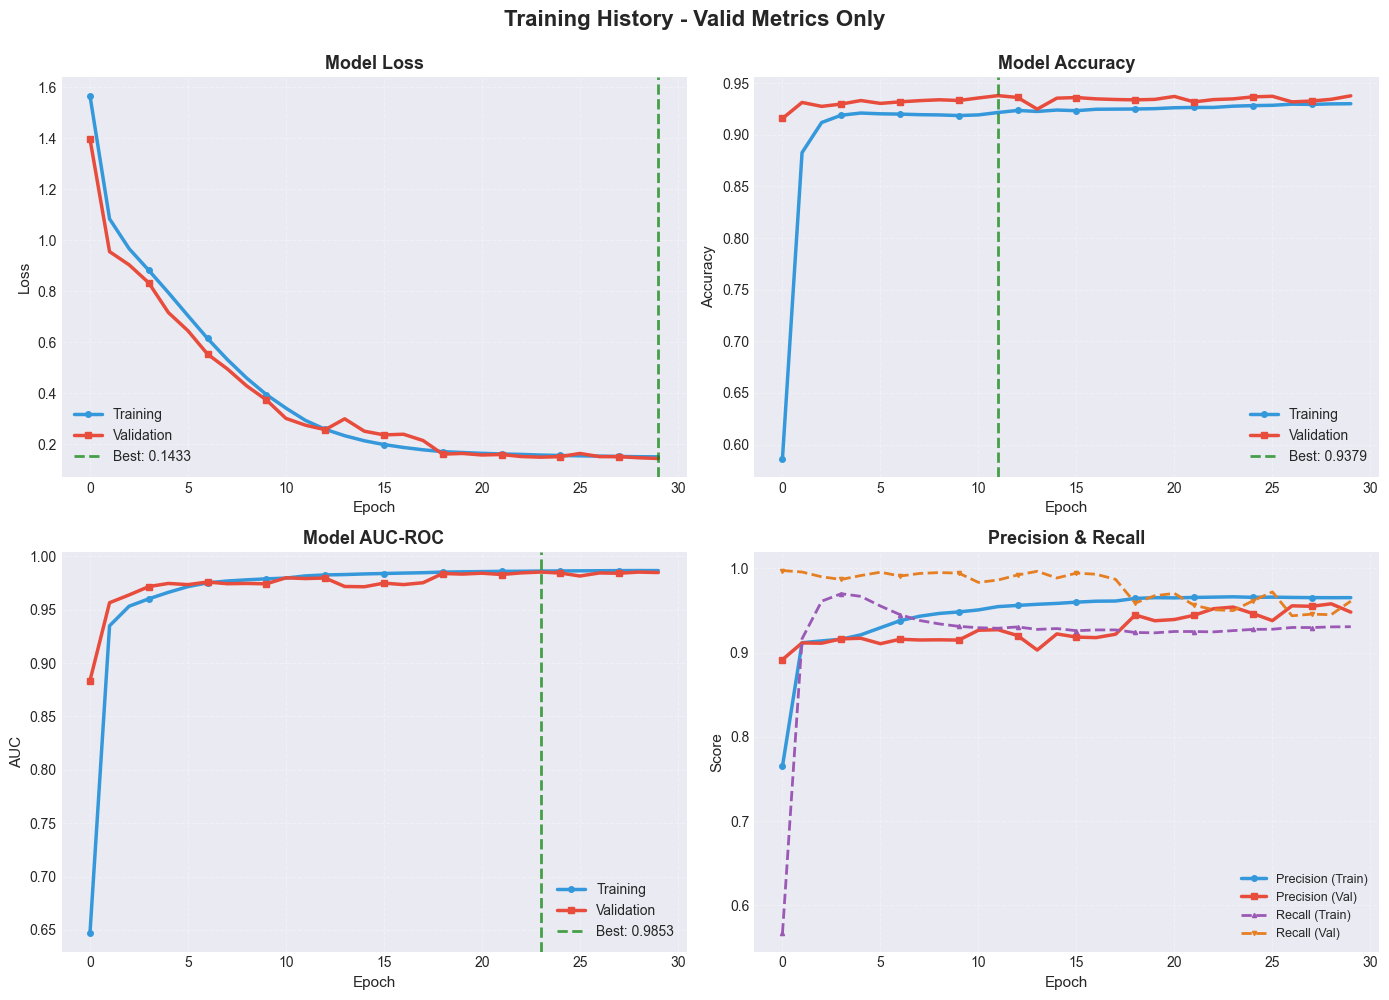

In [358]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training',
         linewidth=2.5, color='#3498db', marker='o', markersize=4,
         markevery=max(1, len(history.history['loss'])//10))
plt.plot(history.history['val_loss'], label='Validation',
         linewidth=2.5, color='#e74c3c', marker='s', markersize=4,
         markevery=max(1, len(history.history['val_loss'])//10))
best_epoch = np.argmin(history.history['val_loss'])
best_value = min(history.history['val_loss'])
plt.axvline(best_epoch, color='green', linestyle='--', alpha=0.7,
            linewidth=2, label=f'Best: {best_value:.4f}')
plt.title('Model Loss', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.legend(fontsize=10)
plt.grid(alpha=0.3, linestyle='--')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training',
         linewidth=2.5, color='#3498db', marker='o', markersize=4,
         markevery=max(1, len(history.history['accuracy'])//10))
plt.plot(history.history['val_accuracy'], label='Validation',
         linewidth=2.5, color='#e74c3c', marker='s', markersize=4,
         markevery=max(1, len(history.history['val_accuracy'])//10))
best_epoch = np.argmax(history.history['val_accuracy'])
best_value = max(history.history['val_accuracy'])
plt.axvline(best_epoch, color='green', linestyle='--', alpha=0.7,
            linewidth=2, label=f'Best: {best_value:.4f}')
plt.title('Model Accuracy', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.legend(fontsize=10)
plt.grid(alpha=0.3, linestyle='--')

plt.subplot(2, 2, 3)
plt.plot(history.history['auc'], label='Training',
         linewidth=2.5, color='#3498db', marker='o', markersize=4,
         markevery=max(1, len(history.history['auc'])//10))
plt.plot(history.history['val_auc'], label='Validation',
         linewidth=2.5, color='#e74c3c', marker='s', markersize=4,
         markevery=max(1, len(history.history['val_auc'])//10))
best_epoch = np.argmax(history.history['val_auc'])
best_value = max(history.history['val_auc'])
plt.axvline(best_epoch, color='green', linestyle='--', alpha=0.7,
            linewidth=2, label=f'Best: {best_value:.4f}')
plt.title('Model AUC-ROC', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('AUC', fontsize=11)
plt.legend(fontsize=10)
plt.grid(alpha=0.3, linestyle='--')

plt.subplot(2, 2, 4)
plt.plot(history.history['precision'], label='Precision (Train)',
         linewidth=2.5, color='#3498db', marker='o', markersize=4,
         markevery=max(1, len(history.history['precision'])//10))
plt.plot(history.history['val_precision'], label='Precision (Val)',
         linewidth=2.5, color='#e74c3c', marker='s', markersize=4,
         markevery=max(1, len(history.history['val_precision'])//10))
plt.plot(history.history['recall'], label='Recall (Train)',
         linewidth=2, color='#9b59b6', linestyle='--', marker='^', markersize=3,
         markevery=max(1, len(history.history['recall'])//10))
plt.plot(history.history['val_recall'], label='Recall (Val)',
         linewidth=2, color='#e67e22', linestyle='--', marker='v', markersize=3,
         markevery=max(1, len(history.history['val_recall'])//10))
plt.title('Precision & Recall', fontsize=13, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Score', fontsize=11)
plt.legend(fontsize=9)
plt.grid(alpha=0.3, linestyle='--')

plt.suptitle('Training History - Valid Metrics Only',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [359]:
def evaluate_model(model, X, y, dataset_name='Dataset', threshold=0.5):
    
    y_pred_proba = model.predict(X, verbose=0).flatten()
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    
    try:
        roc_auc = roc_auc_score(y, y_pred_proba)
    except:
        roc_auc = 0.0
    
    cm = confusion_matrix(y, y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    balanced_acc = (sensitivity + specificity) / 2.0
    
    fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr_val = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'balanced_accuracy': balanced_acc,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'fpr': fpr_val,
        'fnr': fnr_val
    }
    
    print(f"{dataset_name} Performa (Threshold={threshold:.4f})")
    print(f"  Accuracy:          {accuracy:.4f}")
    print(f"  Precision:         {precision:.4f}")
    print(f"  Recall:            {recall:.4f}")
    print(f"  F1 Score:          {f1:.4f}")
    print(f"  ROC-AUC:           {roc_auc:.4f}")
    print(f"  Balanced Accuracy: {balanced_acc:.4f}\n")
    
    return metrics, cm, y_pred_proba


In [360]:
val_metrics, val_cm, val_pred_proba = evaluate_model(
    model, X_val, y_val, 'VALIDATION SET'
)

test_metrics, test_cm, test_pred_proba = evaluate_model(
    model, X_test, y_test, 'TEST SET'
)

VALIDATION SET Performa (Threshold=0.5000)
  Accuracy:          0.9348
  Precision:         0.9541
  Recall:            0.9499
  F1 Score:          0.9520
  ROC-AUC:           0.9865
  Balanced Accuracy: 0.9262

TEST SET Performa (Threshold=0.5000)
  Accuracy:          0.8629
  Precision:         0.8234
  Recall:            0.9559
  F1 Score:          0.8848
  ROC-AUC:           0.9692
  Balanced Accuracy: 0.8524



In [361]:
fpr, tpr, thresholds = roc_curve(y_val, val_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"  Optimal Threshold:    {optimal_threshold:.4f}")
print(f"  TPR at optimal:       {tpr[optimal_idx]:.4f}")
print(f"  FPR at optimal:       {fpr[optimal_idx]:.4f}")
print(f"  Youden's J statistic: {tpr[optimal_idx] - fpr[optimal_idx]:.4f}\n")

test_metrics_opt, test_cm_opt, _ = evaluate_model(
    model, X_test, y_test, 'TEST SET (Optimal Threshold)', optimal_threshold
)


  Optimal Threshold:    0.5786
  TPR at optimal:       0.9318
  FPR at optimal:       0.0767
  Youden's J statistic: 0.8551

TEST SET (Optimal Threshold) Performa (Threshold=0.5786)
  Accuracy:          0.8709
  Precision:         0.8430
  Recall:            0.9408
  F1 Score:          0.8892
  ROC-AUC:           0.9692
  Balanced Accuracy: 0.8631



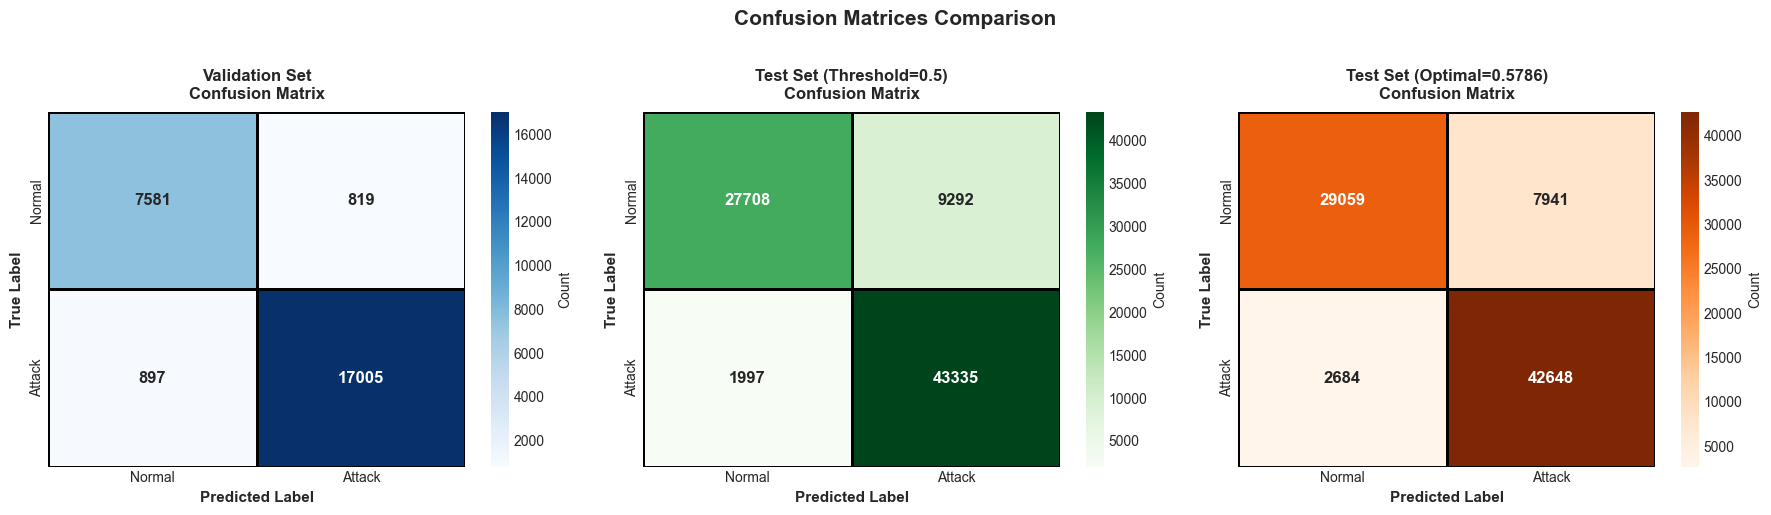

In [362]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'], 
            yticklabels=['Normal', 'Attack'],
            cbar_kws={'label': 'Count'}, linewidths=2, 
            linecolor='black', annot_kws={'size': 12, 'weight': 'bold'})
plt.title('Validation Set\nConfusion Matrix', fontsize=12, fontweight='bold', pad=10)
plt.ylabel('True Label', fontsize=11, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=11, fontweight='bold')

plt.subplot(1, 3, 2)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Attack'], 
            yticklabels=['Normal', 'Attack'],
            cbar_kws={'label': 'Count'}, linewidths=2, 
            linecolor='black', annot_kws={'size': 12, 'weight': 'bold'})
plt.title('Test Set (Threshold=0.5)\nConfusion Matrix', fontsize=12, fontweight='bold', pad=10)
plt.ylabel('True Label', fontsize=11, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=11, fontweight='bold')

plt.subplot(1, 3, 3)
sns.heatmap(test_cm_opt, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Normal', 'Attack'], 
            yticklabels=['Normal', 'Attack'],
            cbar_kws={'label': 'Count'}, linewidths=2, 
            linecolor='black', annot_kws={'size': 12, 'weight': 'bold'})
plt.title(f'Test Set (Optimal={optimal_threshold:.4f})\nConfusion Matrix', 
         fontsize=12, fontweight='bold', pad=10)
plt.ylabel('True Label', fontsize=11, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=11, fontweight='bold')

plt.suptitle('Confusion Matrices Comparison', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


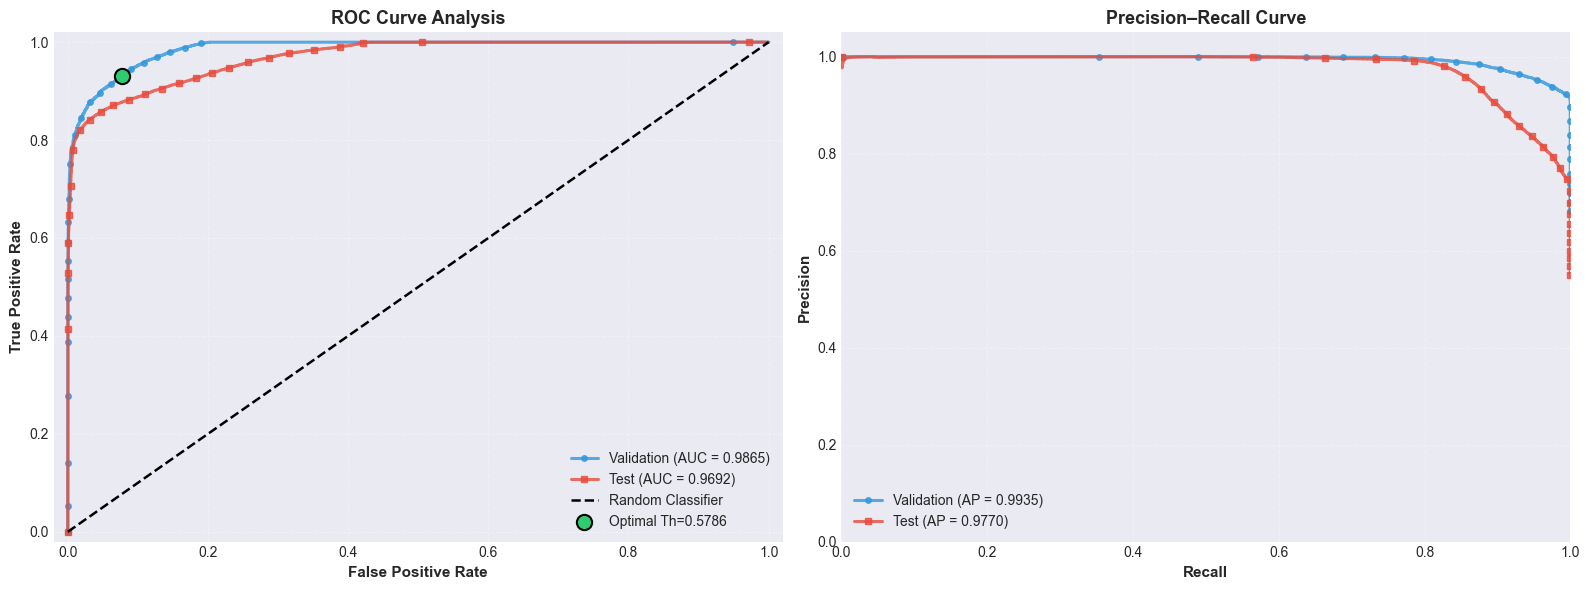

In [363]:
fpr_val, tpr_val, _ = roc_curve(y_val, val_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, test_pred_proba)

precision_val, recall_val, _ = precision_recall_curve(y_val, val_pred_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, test_pred_proba)

ap_val = average_precision_score(y_val, val_pred_proba)
ap_test = average_precision_score(y_test, test_pred_proba)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_val, tpr_val,
         label=f'Validation (AUC = {val_metrics["roc_auc"]:.4f})',
         linewidth=2.2, color='#3498db', marker='o', markersize=4,
         markevery=max(1, len(fpr_val)//25), alpha=0.8)

plt.plot(fpr_test, tpr_test,
         label=f'Test (AUC = {test_metrics["roc_auc"]:.4f})',
         linewidth=2.2, color='#e74c3c', marker='s', markersize=4,
         markevery=max(1, len(fpr_test)//25), alpha=0.8)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1.8, label='Random Classifier')

plt.scatter(fpr[optimal_idx], tpr[optimal_idx],
            color='#2ecc71', s=120, marker='o',
            edgecolors='black', linewidths=1.5,
            label=f'Optimal Th={optimal_threshold:.4f}', zorder=5)

plt.title('ROC Curve Analysis', fontsize=13, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=11, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=11, fontweight='bold')
plt.grid(alpha=0.3, linestyle='--')
plt.legend(fontsize=10, loc='lower right')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])

plt.subplot(1, 2, 2)
plt.plot(recall_val, precision_val,
         label=f'Validation (AP = {ap_val:.4f})',
         linewidth=2.2, color='#3498db', marker='o', markersize=4,
         markevery=max(1, len(recall_val)//25), alpha=0.8)

plt.plot(recall_test, precision_test,
         label=f'Test (AP = {ap_test:.4f})',
         linewidth=2.2, color='#e74c3c', marker='s', markersize=4,
         markevery=max(1, len(recall_test)//25), alpha=0.8)

plt.title('Precision–Recall Curve', fontsize=13, fontweight='bold')
plt.xlabel('Recall', fontsize=11, fontweight='bold')
plt.ylabel('Precision', fontsize=11, fontweight='bold')
plt.grid(alpha=0.3, linestyle='--')
plt.legend(fontsize=10, loc='lower left')
plt.xlim([0, 1])
plt.ylim([0, 1.05])

plt.tight_layout()
plt.show()

In [364]:
y_pred_test = (test_pred_proba >= 0.5).astype(int)
y_pred_test_opt = (test_pred_proba >= optimal_threshold).astype(int)

print("CLASSIFICATION REPORT - TEST SET (Threshold=0.5)")
print(classification_report(y_test, y_pred_test, 
                          target_names=['Normal', 'Attack'], 
                          digits=4))

print(f"CLASSIFICATION REPORT - TEST SET (Optimal={optimal_threshold:.4f})")
print(classification_report(y_test, y_pred_test_opt, 
                          target_names=['Normal', 'Attack'], 
                          digits=4))


CLASSIFICATION REPORT - TEST SET (Threshold=0.5)
              precision    recall  f1-score   support

      Normal     0.9328    0.7489    0.8308     37000
      Attack     0.8234    0.9559    0.8848     45332

    accuracy                         0.8629     82332
   macro avg     0.8781    0.8524    0.8578     82332
weighted avg     0.8726    0.8629    0.8605     82332

CLASSIFICATION REPORT - TEST SET (Optimal=0.5786)
              precision    recall  f1-score   support

      Normal     0.9154    0.7854    0.8454     37000
      Attack     0.8430    0.9408    0.8892     45332

    accuracy                         0.8709     82332
   macro avg     0.8792    0.8631    0.8673     82332
weighted avg     0.8756    0.8709    0.8696     82332



In [365]:
metrics_df = pd.DataFrame({
    'Validation': [
        val_metrics['accuracy'],
        val_metrics['precision'],
        val_metrics['recall'],
        val_metrics['f1_score'],
        val_metrics['roc_auc'],
        val_metrics['balanced_accuracy'],
        val_metrics['sensitivity'],
        val_metrics['specificity']
    ],
    'Test (Th=0.5)': [
        test_metrics['accuracy'],
        test_metrics['precision'],
        test_metrics['recall'],
        test_metrics['f1_score'],
        test_metrics['roc_auc'],
        test_metrics['balanced_accuracy'],
        test_metrics['sensitivity'],
        test_metrics['specificity']
    ],
    'Test (Optimal)': [
        test_metrics_opt['accuracy'],
        test_metrics_opt['precision'],
        test_metrics_opt['recall'],
        test_metrics_opt['f1_score'],
        test_metrics_opt['roc_auc'],
        test_metrics_opt['balanced_accuracy'],
        test_metrics_opt['sensitivity'],
        test_metrics_opt['specificity']
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 
          'Balanced Acc', 'Sensitivity', 'Specificity'])

print(metrics_df.to_string())

              Validation  Test (Th=0.5)  Test (Optimal)
Accuracy          0.9348         0.8629          0.8709
Precision         0.9541         0.8234          0.8430
Recall            0.9499         0.9559          0.9408
F1-Score          0.9520         0.8848          0.8892
ROC-AUC           0.9865         0.9692          0.9692
Balanced Acc      0.9262         0.8524          0.8631
Sensitivity       0.9499         0.9559          0.9408
Specificity       0.9025         0.7489          0.7854


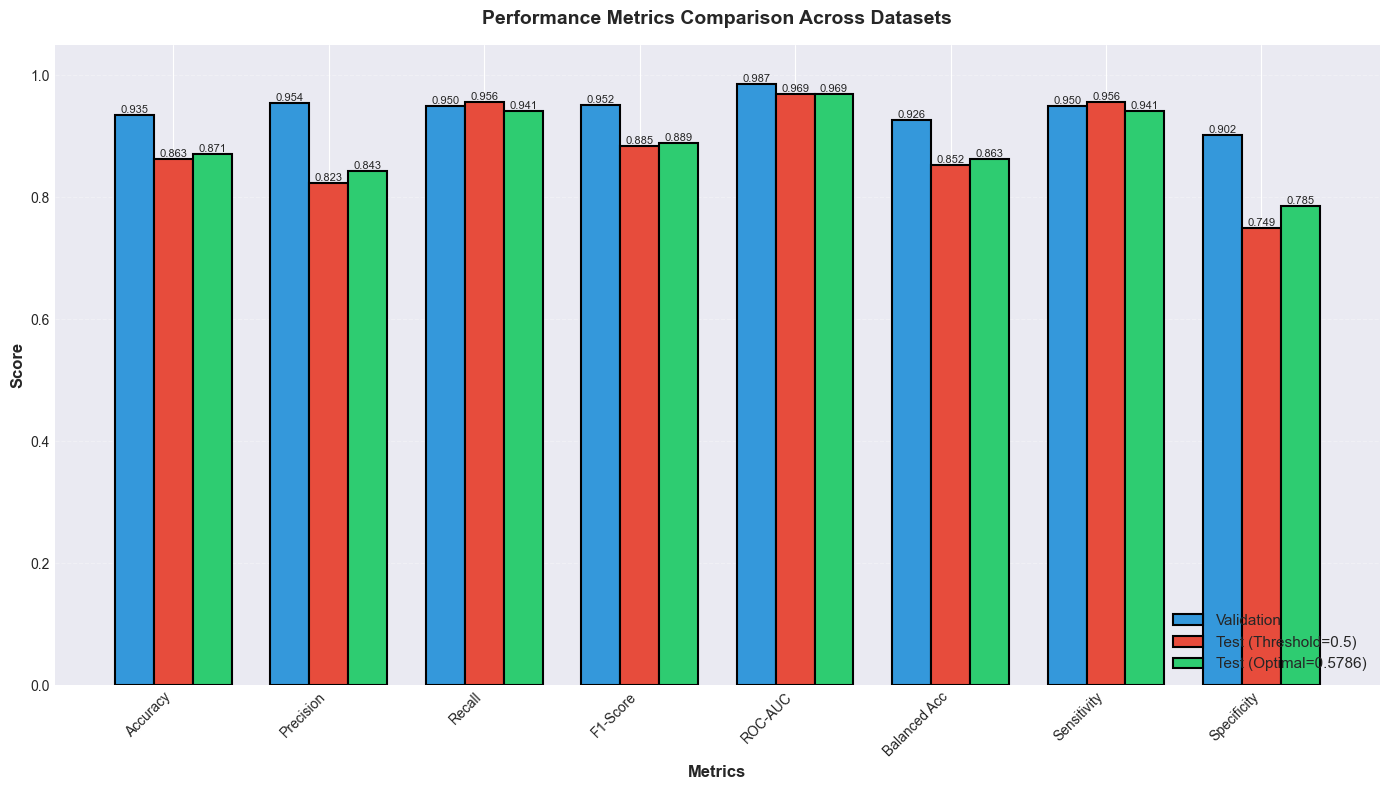

In [366]:
plt.figure(figsize=(14, 8))

x = np.arange(len(metrics_df.index))
width = 0.25

bars1 = plt.bar(x - width, metrics_df['Validation'], width, 
               label='Validation', color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = plt.bar(x, metrics_df['Test (Th=0.5)'], width, 
               label='Test (Threshold=0.5)', color='#e74c3c', edgecolor='black', linewidth=1.5)
bars3 = plt.bar(x + width, metrics_df['Test (Optimal)'], width, 
               label=f'Test (Optimal={optimal_threshold:.4f})', color='#2ecc71', edgecolor='black', linewidth=1.5)

plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.title('Performance Metrics Comparison Across Datasets', 
         fontsize=14, fontweight='bold', pad=15)
plt.xticks(x, metrics_df.index, rotation=45, ha='right')
plt.legend(fontsize=11, loc='lower right', framealpha=0.9)
plt.ylim([0, 1.05])
plt.grid(axis='y', alpha=0.3, linestyle='--')

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

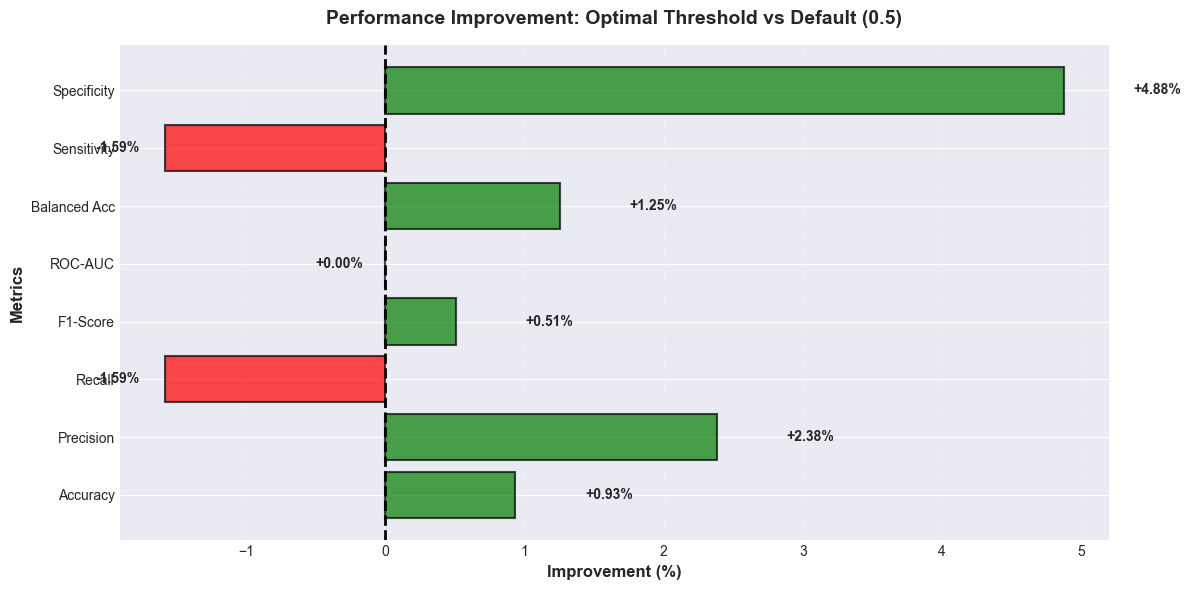

In [367]:
improvement = ((metrics_df['Test (Optimal)'] - metrics_df['Test (Th=0.5)']) / 
               metrics_df['Test (Th=0.5)'] * 100)

plt.figure(figsize=(12, 6))

colors = ['green' if x > 0 else 'red' if x < 0 else 'gray' for x in improvement]
bars = plt.barh(range(len(improvement)), improvement.values, color=colors, 
               edgecolor='black', linewidth=1.5, alpha=0.7)

plt.yticks(range(len(improvement)), improvement.index)
plt.xlabel('Improvement (%)', fontsize=12, fontweight='bold')
plt.ylabel('Metrics', fontsize=12, fontweight='bold')
plt.title('Performance Improvement: Optimal Threshold vs Default (0.5)', 
         fontsize=14, fontweight='bold', pad=15)
plt.axvline(x=0, color='black', linestyle='--', linewidth=2)
plt.grid(axis='x', alpha=0.3, linestyle='--')

for i, (bar, v) in enumerate(zip(bars, improvement.values)):
    plt.text(v + 0.5 if v > 0 else v - 0.5, i, f'{v:+.2f}%', 
            va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

In [368]:
model.save('intrusion_detection_transformer_final.keras')
print("Model saved: intrusion_detection_transformer_final.keras")

joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved: scaler.pkl")

joblib.dump(label_encoders, 'label_encoders.pkl')
print("Label encoders saved: label_encoders.pkl")

joblib.dump(class_weights, 'class_weights.pkl')
print("Class weights saved: class_weights.pkl")

evaluation_results = {
    'validation_metrics': val_metrics,
    'test_metrics': test_metrics,
    'test_metrics_optimal': test_metrics_opt,
    'validation_cm': val_cm,
    'test_cm': test_cm,
    'test_cm_optimal': test_cm_opt,
    'history': history.history,
    'optimal_threshold': optimal_threshold,
    'class_weights': class_weights,
    'metrics_comparison': metrics_df.to_dict()
}
joblib.dump(evaluation_results, 'evaluation_results.pkl')
print("Evaluation results saved: evaluation_results.pkl")

preprocessing_config = {
    'numerical_features': numerical_cols,
    'categorical_features': categorical_cols,
    'num_features': NUM_FEATURES,
    'optimal_threshold': optimal_threshold,
    'model_config': {
        'embed_dim': EMBED_DIM,
        'num_heads': NUM_HEADS,
        'ff_dim': FF_DIM,
        'num_transformer_blocks': NUM_TRANSFORMER_BLOCKS,
        'dropout_rate': DROPOUT_RATE,
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE
    }
}
joblib.dump(preprocessing_config, 'preprocessing_config.pkl')
print("Preprocessing config saved: preprocessing_config.pkl")

print("\nSaved Files:")
files_saved = [
    'intrusion_detection_transformer_final.keras',
    'scaler.pkl',
    'label_encoders.pkl',
    'class_weights.pkl',
    'evaluation_results.pkl',
    'preprocessing_config.pkl'
]

for i, file in enumerate(files_saved, 1):
    print(f"{i}. {file}")


Model saved: intrusion_detection_transformer_final.keras
Scaler saved: scaler.pkl
Label encoders saved: label_encoders.pkl
Class weights saved: class_weights.pkl
Evaluation results saved: evaluation_results.pkl
Preprocessing config saved: preprocessing_config.pkl

Saved Files:
1. intrusion_detection_transformer_final.keras
2. scaler.pkl
3. label_encoders.pkl
4. class_weights.pkl
5. evaluation_results.pkl
6. preprocessing_config.pkl


In [369]:
def predict_intrusion(data, model_path='intrusion_detection_transformer_final.keras',
                     scaler_path='scaler.pkl', 
                     encoders_path='label_encoders.pkl',
                     config_path='preprocessing_config.pkl'):
    
    model = tf.keras.models.load_model(model_path, custom_objects={
        'TransformerBlock': TransformerBlock,
        'FeatureEmbedding': FeatureEmbedding
    })
    
    scaler = joblib.load(scaler_path)
    label_encoders = joblib.load(encoders_path)
    config = joblib.load(config_path)
    
    if isinstance(data, pd.DataFrame):
        df = data.copy()
    else:
        df = pd.DataFrame([data])
    
    for col in ['id', 'label', 'attack_cat']:
        if col in df.columns:
            df = df.drop([col], axis=1)
    
    for col in config['categorical_features']:
        if col in df.columns:
            df[col] = df[col].fillna('unknown').astype(str)
            le = label_encoders[col]
            df[col] = df[col].apply(lambda x: x if x in le.classes_ else le.classes_[0])
            df[col] = le.transform(df[col])
    
    for col in config['numerical_features']:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    
    df[config['numerical_features']] = scaler.transform(df[config['numerical_features']])

    feature_order = config['numerical_features'] + config['categorical_features']
    X = df[feature_order].values
    X = X.reshape((X.shape[0], X.shape[1], 1))

    probabilities = model.predict(X, verbose=0).flatten()
    predictions = (probabilities >= config['optimal_threshold']).astype(int)
    
    results = []
    for i in range(len(predictions)):
        results.append({
            'prediction': 'Attack' if predictions[i] == 1 else 'Normal',
            'probability': float(probabilities[i]),
            'confidence': float(probabilities[i]) if predictions[i] == 1 else float(1 - probabilities[i]),
            'threshold_used': config['optimal_threshold']
        })
    
    return results

In [373]:
np.random.seed(42)
sample_indices = np.random.choice(len(test_data), 100, replace=False)
test_samples = test_data.iloc[sample_indices].copy()
true_labels = test_samples['label'].values

test_samples_clean = test_samples.drop(['label', 'attack_cat'], axis=1)
if 'id' in test_samples_clean.columns:
    test_samples_clean = test_samples_clean.drop(['id'], axis=1)

predictions = predict_intrusion(test_samples_clean)

correct = 0
for i, (pred, true_label) in enumerate(zip(predictions, true_labels)):
    true_class = 'Attack' if true_label == 1 else 'Normal'
    is_correct = pred['prediction'] == true_class
    if is_correct:
        correct += 1
    
    status_symbol = "✓" if is_correct else "✗"
    status_text = "CORRECT" if is_correct else "INCORRECT"
    
    print(f"\nSample {i+1}:")
    print(f"  Predicted: {pred['prediction']:<10} (Probability: {pred['probability']:.4f})")
    print(f"  Actual:    {true_class:<10}")
    print(f"  Confidence: {pred['confidence']:.4f}")
    print(f"  Status:    {status_symbol} {status_text}")



Sample 1:
  Predicted: Attack     (Probability: 0.9996)
  Actual:    Normal    
  Confidence: 0.9996
  Status:    ✗ INCORRECT

Sample 2:
  Predicted: Normal     (Probability: 0.0000)
  Actual:    Attack    
  Confidence: 1.0000
  Status:    ✗ INCORRECT

Sample 3:
  Predicted: Normal     (Probability: 0.0000)
  Actual:    Attack    
  Confidence: 1.0000
  Status:    ✗ INCORRECT

Sample 4:
  Predicted: Attack     (Probability: 0.9920)
  Actual:    Normal    
  Confidence: 0.9920
  Status:    ✗ INCORRECT

Sample 5:
  Predicted: Attack     (Probability: 0.9980)
  Actual:    Attack    
  Confidence: 0.9980
  Status:    ✓ CORRECT

Sample 6:
  Predicted: Normal     (Probability: 0.0000)
  Actual:    Attack    
  Confidence: 1.0000
  Status:    ✗ INCORRECT

Sample 7:
  Predicted: Normal     (Probability: 0.0000)
  Actual:    Normal    
  Confidence: 1.0000
  Status:    ✓ CORRECT

Sample 8:
  Predicted: Attack     (Probability: 0.9971)
  Actual:    Attack    
  Confidence: 0.9971
  Status:    